In [1]:
%matplotlib inline
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt


# Image Denoising using MRFs

### Real Image
![](emoji.png)
### Noisy Image
![](emoji-noisy.png)

## Goal: Recover the real image.

Let's denote the real image by $X$ and the noisy image by $Y$. $X$ and $Y$ are binary images where each pixel can take a value from $\{-1, +1\}$. Each pixel of $X$ and $Y$ represents a node in the MRF. 

Question: Which nodes are observed in this MRF?

Answer: The ones that represent $Y$ because we only have access to the noisy image.

In [2]:
# Helper functions to load, binarize, and add noise to the image

def load_image(fname):
    img = Image.open(fname)
    img_gray = img.convert('L')
    img_eq = ImageOps.autocontrast(img_gray)
    img_eq = np.array(img_eq.getdata()).reshape((img_eq.size[1], -1))
    return img_eq

def binarize_image(img_eq):
    img_bin = np.copy(img_eq)
    img_bin[img_bin < 128] = -1
    img_bin[img_bin >= 128] = 1
    return img_bin

def add_noise(img_bin, noise_prob=0.1):
    noise = np.random.choice([-1, 1], size=img_bin.shape, p=[noise_prob, 1-noise_prob])
    img_bin = np.copy(img_bin)
    img_bin *= noise
    return img_bin

Question: Add edges to the nodes. 

Hint: How is each pixel $x_{i,j}$ in $X$ related to other pixels in $X$ and $Y$? 

Answer: Each pixel $x_{i,j}$ is connected to the corresponding pixel $y_{i,j}$ in $Y$ and to the pixel in the neighborhood of $x_{i,j}$.

![text](graph.png)
(Image from Bishop's PRML)

Now there are two types of edges: the ones between $x_{i,j}$ and $y_{i,j}$, and the ones between $x_{i,j}$ and its neighbors. 

Question: Choose suitable energy functions for both cases. 

Hint: Pixels in images are generally similar to their neighbors. We also expect that $x_{i,j}$ and $y_{i,j}$ will have the same value most of the time. Choose energy functions such that the energy is low when $x_{i,j}$ agrees with its neighbors and $y_{i,j}$.

Answer: 

$
\begin{align}
\psi(x_{i,j},y_{i,j}) = -\alpha x_{i,j}y_{i,j}\\
\psi(x_{i,j},x_{i,j}^*) = -\beta x_{i,j}x_{i,j}^*
\end{align}
$

where $x_{i,j}^*$ is a neighbor of $x_{i,j}$.

In [3]:
def index_oob(index, size):
    return (index[0] < 0 
            or index[0] >= size[0] 
            or index[1] < 0
            or index[1] >= size[1])

'''
Params:
X: The image X.
loc: tuple of location (i, j)
y_at_loc: value of image Y at (i, j)
x_val: +1 or -1

This function computes the local energy when the value of pixel X[i,j] is set to x_val.
'''

def compute_energy(X, loc, y_at_loc, x_val):
    i, j = loc
    energy = -alpha * y_at_loc * x_val
    shifts = [[0, 1], [1, 0], [-1, 0], [0, -1]]
    for s in shifts:
        if not index_oob((i + s[0], j + s[1]), X.shape):
            energy += -beta * x_val * X[i + s[0]][j + s[1]]
    return energy

$$E(X, Y) = \sum_{i,j}\left[-\alpha x_{i,j}y_{i,j} +\sum_{x_{i,j}^*\:\in\:\text{neighbors}(x_{i,j})}-\beta x_{i,j}x_{i,j}^*\right]$$

The probability is now given by
$$p(X, Y) = \frac{1}{Z}\exp\{-E(X, Y)\}$$

We wish to find the value of $X$ that has high probability. One way to do this is using iterated conditional modes or ICM which is a co-ordinate ascent method. 

1. Loop over each pixel in $X$.
2. Compute unnormalized $p(x_{i,j}=-1|X\setminus x_{i,j},Y)$ and $p(x_{i,j}=+1|X\setminus x_{i,j},Y)$.
3. Set the pixel's value to -1 or +1 depending on which probability is higher.
4. Repeat steps 1-3 until there's no change in $X$.

In [4]:
'''
This function denoises the input image Y.
'''
def denoise_image(Y, max_iter=1000):
    X = np.copy(Y)
    for itr in range(max_iter):
        prev_X = np.copy(X)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                neg_prob = -compute_energy(X, (i, j), Y[i, j], -1)
                pos_prob = -compute_energy(X, (i, j), Y[i, j], 1)
                X[i, j] = -1 if neg_prob > pos_prob else 1
        if np.allclose(prev_X, X):
            print('Converged')
            break
    return X

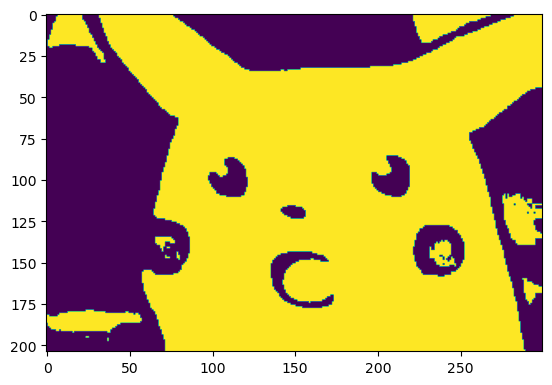

In [9]:
# Choose suitable values for alpha and beta
alpha, beta = 0.1, 10.0
img = binarize_image(load_image('pikachu.jpg'))
plt.imshow(img)
plt.show()

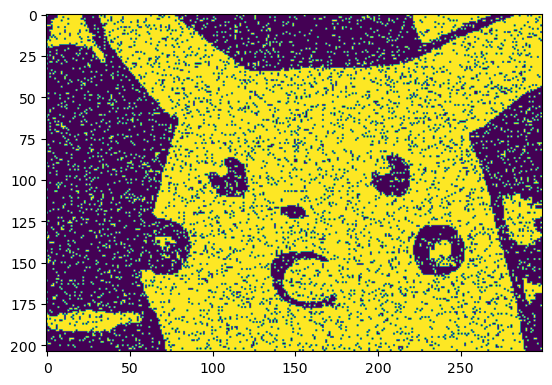

In [10]:
Y = add_noise(img)
plt.imshow(Y)
plt.show()

In [11]:
Y_denoised = denoise_image(Y)

Converged


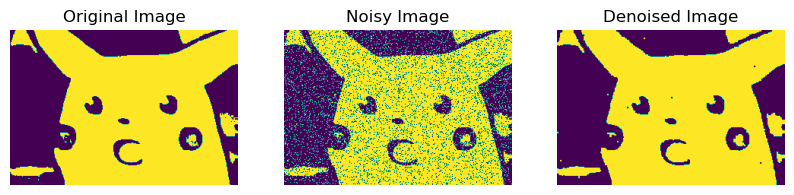

In [12]:
# Plot the images

fig, axn = plt.subplots(1, 3, figsize=(10, 5))
axn[0].imshow(img)
axn[0].axis('off')
axn[0].set_title('Original Image')
axn[1].imshow(Y)
axn[1].axis('off')
axn[1].set_title('Noisy Image')
axn[2].imshow(Y_denoised)
axn[2].axis('off')
axn[2].set_title('Denoised Image')
plt.show()